# 분류

## 결정 트리

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156, min_samples_leaf=4)
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=4, random_state=156)

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names,
                feature_names=iris_data.feature_names, impurity=True, filled=True)

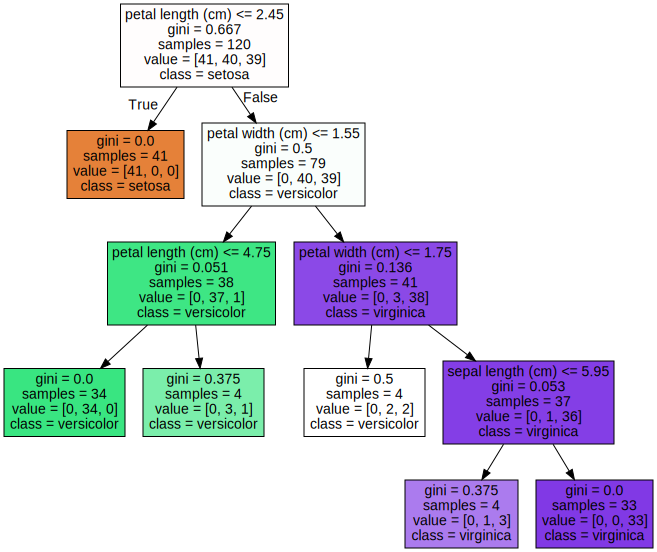

In [3]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

Feature importance:
[0.006 0.    0.546 0.448]
sepal length (cm) : 0.006
sepal width (cm) : 0.000
petal length (cm) : 0.546
petal width (cm) : 0.448


<Axes: >

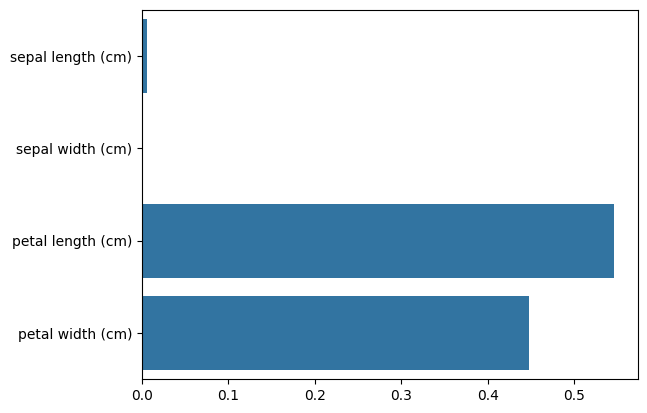

In [4]:
import seaborn as sns
import numpy as np
%matplotlib inline

print(f'Feature importance:\n{np.round(dt_clf.feature_importances_, 3)}')

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
  print(f'{name} : {value:.3f}')

sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

### 결정 트리 과적합

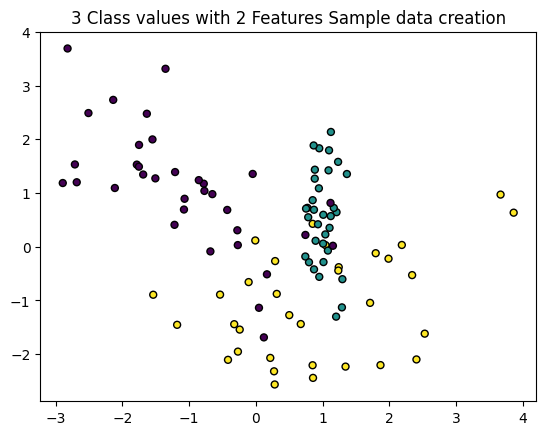

In [5]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class values with 2 Features Sample data creation')

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                           n_classes=3, n_clusters_per_class=1, random_state=0)
plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolor='k')

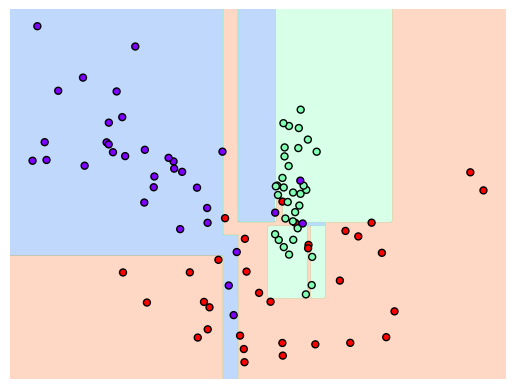

In [6]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np


# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()

    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()

    # 호출 파라미터로 들어온 training 데이타로 model 학습 .
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행.
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # contourf() 를 이용하여 class boundary 를 visualization 수행.
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)


dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

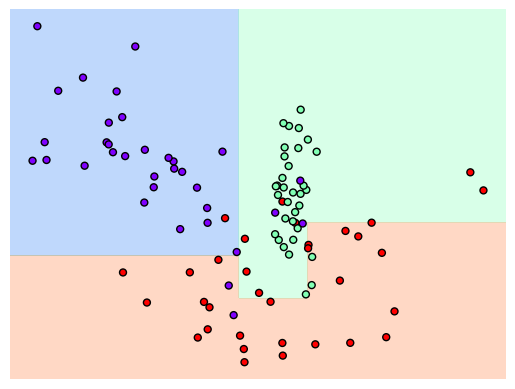

In [7]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

### 실습 - 사용자 행동 인식 데이터 세트

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 피처명과 인덱스가 공백으로 분리. 피처명만 뜯어내는작업.
feature_name_df = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/features.txt', sep='\s+',
                              header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [10]:
# 중복 피처명 처리
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()
# 총 42개의 피처명이 중

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [5]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), # cumcount: 그룹마다 데이터의 누적합 반환
                                columns=['dup_cnt'])

  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                            'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                              if x[1] > 0 else x[0], axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset():

  feature_name_df = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/features.txt', sep='\s+',
                                header=None, names=['column_index', 'column_name'])

  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  X_train = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/train/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/test/X_test.txt', sep='\s+', names=feature_name)

  y_train = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/train/y_train.txt', sep='\s+', names=['action'])
  y_test = pd.read_csv('/content/drive/MyDrive/UCI HAR Dataset/test/y_test.txt', sep='\s+', names=['action'])

  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [14]:
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [15]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'Decision Tree Accuracy: {accuracy:.4f}')

print(f'DecisionTreeClassifier hyperparameters:\n{dt_clf.get_params()}')

Decision Tree Accuracy: 0.8548
DecisionTreeClassifier hyperparameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [17]:
# max_depth 조정
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split': [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'GridSearchCV max accuracy: {grid_cv.best_score_:.4f}')
print(f'GridSearchCV best parameters: {grid_cv.best_params_:}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV max accuracy: 0.8549
GridSearchCV best parameters: {'max_depth': 8, 'min_samples_split': 16}


In [18]:
# 파라미터 변화에 따른 성능 변화 확인
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


In [19]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depths:
  dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
  dt_clf.fit(X_train, y_train)
  pred = dt_clf.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  print(f'max_depth: {depth} accuracy: {accuracy:.4f}')

max_depth: 6 accuracy: 0.8551
max_depth: 8 accuracy: 0.8717
max_depth: 10 accuracy: 0.8599
max_depth: 12 accuracy: 0.8571
max_depth: 16 accuracy: 0.8599
max_depth: 20 accuracy: 0.8565
max_depth: 24 accuracy: 0.8565


In [20]:
params = {
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print(f'GridSearchCV max accuracy: {grid_cv.best_score_:.4f}')
print(f'GridSearchCV best parameters: {grid_cv.best_params_:}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [ ]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy= accuracy_score(y_test, pred1)
print(f'accuracy: {accuracy:.4f}')

accuracy: 0.8717


<Axes: title={'center': 'Feature importances Top 20'}, xlabel='None', ylabel='None'>

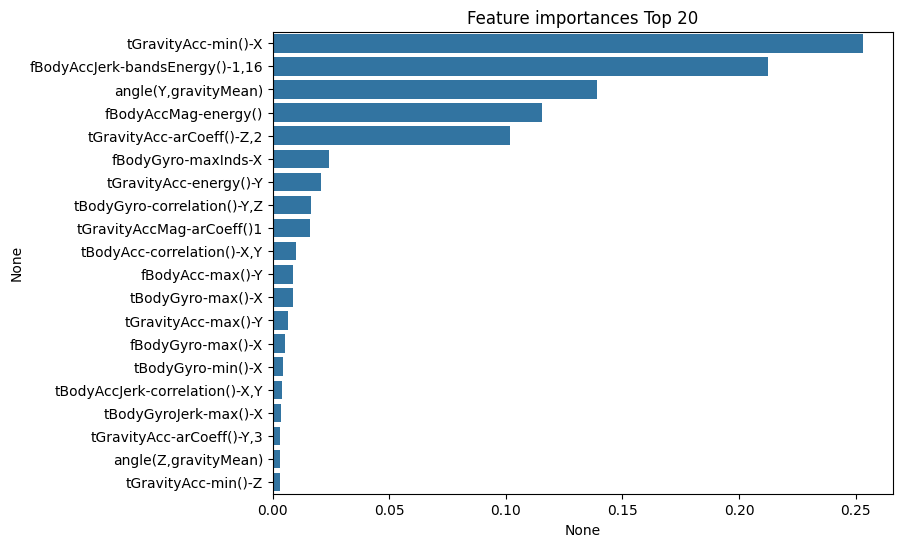

In [ ]:
# 피처 중요도 확인
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)

## 앙상블 학습

### 보팅

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(f'VotingClassifier accuracy: {accuracy_score(y_test, pred):.4f}')

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name=classifier.__class__.__name__
  print(f'{class_name} accuracy: {accuracy_score(y_test, pred):.4f}')

VotingClassifier accuracy: 0.9561
LogisticRegression accuracy: 0.9474
KNeighborsClassifier accuracy: 0.9386


## 랜덤 포레스트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'RandomFoerstClassifier accuracy: {accuracy:.4f}')

RandomFoerstClassifier accuracy: 0.9196


### 랜덤 포레스트 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 6, 12],
    'min_samples_split': [2, 8, 16]
}

rf_clf = RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=-1) # n_jobs=-1: 모든 CPU 코어 이용해 학습
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv = 2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('best parameter:\n', grid_cv.best_params_)
print(f'best accuracy: {grid_cv.best_score_:.4f}')

best parameter:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
best accuracy: 0.9165


In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, pred):.4f}')

Accuracy: 0.9260


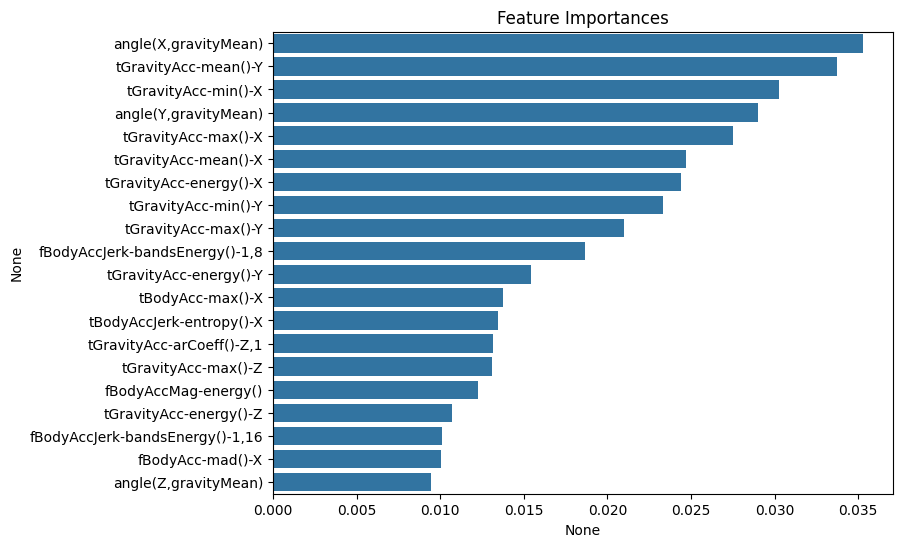

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## GBM

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f'accuracy: {gb_accuracy:.4f}')
print(f'runtime: {time.time() - start_time():.1f}')

KeyboardInterrupt: 

In [25]:
!pip install xgboost

In [8]:
import xgboost as xgb
from xgboost import XGBClassifier

In [9]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [10]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [11]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=.2, random_state=156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [12]:
# 파이썬 래퍼 XGBoost는 ndarray 대신 DMatrix로 바꿔야 함
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [13]:
params = {
    'max_depth': 3,
    'eta': .05,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
num_rounds = 400

In [14]:
# train set과 evaluation set을 명기
eval_list = [(dtr, 'train'), (dval, 'eval')]

xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [15]:
pred_probs = xgb_model.predict(dtest)
print('predict result')
print(np.round(pred_probs[:10], 3))

preds = [1 if x > .5 else 0 for x in pred_probs]
print(preds[:10])

predict result
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1 스코어: {f1:.4f}, AUC: {roc_auc:.4f}')


get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, f1 스코어: 0.9740, AUC: 0.9965


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

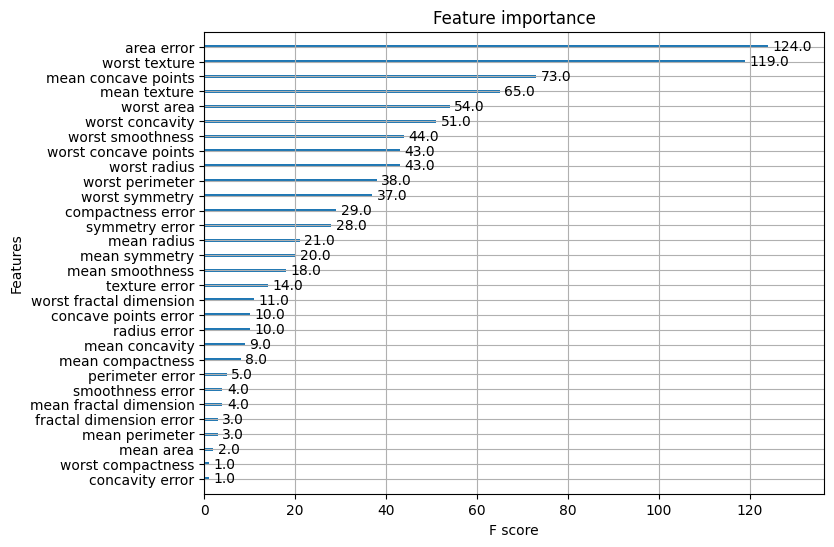

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgb_model, ax=ax)

In [23]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [24]:
w_pred_proba

array([8.8368094e-01, 2.7957589e-03, 8.9875424e-01, 1.8748048e-01,
       9.9204481e-01, 9.9990714e-01, 9.9954444e-01, 9.9904817e-01,
       9.9527210e-01, 1.9664205e-04, 4.6661074e-04, 3.4986527e-04,
       9.9978751e-01, 9.9986005e-01, 9.9762732e-01, 9.8767686e-01,
       9.9667823e-01, 9.9986362e-01, 9.9907458e-01, 9.9931550e-01,
       9.2988275e-04, 5.2080876e-01, 2.3583724e-04, 9.9992442e-01,
       4.3429193e-04, 9.2019814e-01, 3.9606029e-03, 4.6779244e-04,
       9.9862242e-01, 4.9763393e-02, 9.9800545e-01, 5.4994889e-04,
       9.8897702e-01, 7.6986468e-01, 3.9233305e-03, 2.1881066e-04,
       9.9858993e-01, 9.9847704e-01, 2.4087387e-01, 9.9977928e-01,
       1.6901281e-01, 9.9737787e-01, 9.9952006e-01, 9.9942517e-01,
       9.9896443e-01, 9.8763484e-01, 1.0981970e-02, 9.9921489e-01,
       9.9855250e-01, 9.9946564e-01, 9.9679536e-01, 4.8968371e-04,
       9.9886876e-01, 9.9970585e-01, 9.9932480e-01, 9.9932778e-01,
       9.9977881e-01, 9.9157953e-01, 9.9941683e-01, 8.7043911e

In [25]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, f1 스코어: 0.9806, AUC: 0.9954


In [26]:
xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [27]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[36  1]
 [ 2 75]]
정확도: 0.9737, 정밀도: 0.9868, 재현율: 0.9740, f1 스코어: 0.9804, AUC: 0.9951


In [30]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

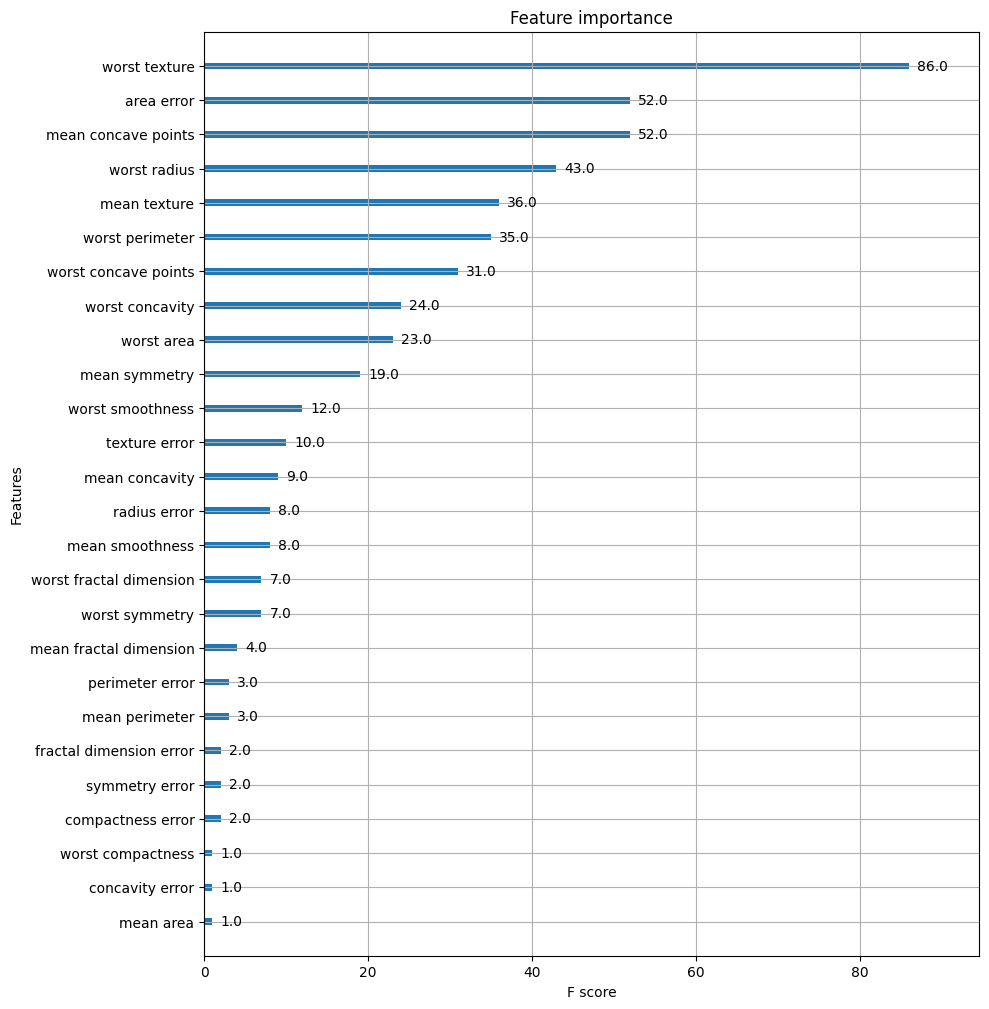

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_wrapper, ax=ax)